In [3]:
from imports_func import *
from dbase import *

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_full.npy') 
#X2=np.load('/home/miquel/ForMiquel/CLEAN2/X_c2_1j.npy')
#X3=np.load('/home/miquel/ForMiquel/CLEAN2/X_c3_1j.npy')
#X=np.concatenate((X1, X2), axis=1)
#X=np.concatenate((X, X3), axis=1)
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full.npy')

In [3]:
def cross_validation_analysis(X, y, clf, clf2, clf3, splits, linspace):
    
    l=len(linspace)
    l2=X.shape[1]
    ACC=np.zeros((l))
    ROC=np.zeros((l))
    F1=np.zeros((l))
    W=np.zeros((l2))
    

    #X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X, y, test_size=.25, random_state=18)
    spl1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=20)
    for train_index, test_index in spl1.split(X, y):
        X_train_g = X[train_index,:]
        y_train_g = y[train_index]
        X_test_g = X[test_index,:]
        y_test_g = y[test_index]
    
    print(y_test_g)
    
    spl2 = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    
    for train_index, test_index in spl2.split(X_train_g, y_train_g):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        
        clf=clf1
        clf.fit(X_train, y_train)
        w = np.transpose(clf.coef_) #importance of each feature for classification
        w=np.abs(w)
        w = np.reshape(w,l2)
        W = np.vstack((W, w)) #add weights of each split in W matrix
        aux3=y_train
        aux4=y_test
        
        acc_l=[]
        roc_l=[]
        f1_l=[]
        
        for n in linspace:
            
            clf=clf2
            aux1=X_train
            aux2=X_test
    
            n=n.astype(int)
            idxs=w.argsort()[-n:][::-1]
            idxs=np.sort(idxs)      
            mask = np.zeros(l2, dtype=bool)
            mask[idxs]=True
            aux1=aux1[:,mask] #take columns of features with large (abs value) weights
            aux2=aux2[:,mask]
            y_score = clf.fit(aux1, aux3).decision_function(aux2)
            pred = clf.predict(aux2)
            acc = accuracy_score(aux4, pred)
            roc=roc_auc_score(aux4, y_score)    
            f1=f1_score(aux4, pred)        
            acc_l.append(acc)
            roc_l.append(roc)
            f1_l.append(f1)
            
        ACC = np.vstack((ACC, acc_l))
        ROC = np.vstack((ROC, roc_l))
        F1 = np.vstack((F1, f1_l))
        print(ACC.shape)
        
            
    ACC=ACC[1:,:]
    ROC=ROC[1:,:]
    F1=F1[1:,:]
    W=W[1:,:]
    
    m1=np.mean(ACC, axis=0)
    dv1=np.std(ACC, axis=0)
    m2=np.mean(ROC, axis=0)
    dv2=np.std(ROC, axis=0)
    m3=np.mean(F1, axis=0)
    dv3=np.std(F1, axis=0)
    
    f, axes = plt.subplots(2, 3, figsize=(16, 7))
    axes[0,0].plot(linspace, m1)
    axes[0,0].set_xlabel('features')
    axes[0,0].set_ylabel('ACC mean') 
    axes[0,1].plot(linspace, m2)
    axes[0,1].set_xlabel('features')
    axes[0,1].set_ylabel('ROC mean')
    axes[0,2].plot(linspace, m3)
    axes[0,2].set_xlabel('features')
    axes[0,2].set_ylabel('F1 mean')
    axes[1,0].plot(linspace, dv1)
    axes[1,0].set_xlabel('features')
    axes[1,0].set_ylabel('ACC std') 
    axes[1,1].plot(linspace, dv2)
    axes[1,1].set_xlabel('features')
    axes[1,1].set_ylabel('ROC std')
    axes[1,2].plot(linspace, dv3)
    axes[1,2].set_xlabel('features')
    axes[1,2].set_ylabel('F1 std')
    
    plt.show()
    
    #obtain maximum from F1 function and according to this max take indices of mean/std weights array to choose the
    #features to train and test the model with all the dataset
    
    maxi=np.argmax(m1+m2+m3)
    feat=linspace[maxi]
    print("maximum at ", feat, " features")
    
    mW=np.mean(W, axis=0)
    sW=np.std(W, axis=0)
    w=mW/sW
    w = np.reshape(w,l2)
    feat=feat.astype(int)
    idxs=w.argsort()[-feat:][::-1]
    idxs=np.sort(idxs)
    mask = np.zeros(l2, dtype=bool)
    mask[idxs]=True
    X_train_g=X_train_g[:,mask] #take columns of features with large (abs value) weights
    X_test_g=X_test_g[:,mask]
    
    y_score = clf3.fit(X_train_g, y_train_g).decision_function(X_test_g)
    #y_score_t = clf3.decision_function(X_train_g)
    
    #pred_t = clf3.predict(X_train_g)
    pred = clf3.predict(X_test_g)
    
    #acc_t = accuracy_score(y_train_g, pred_t)
    acc = accuracy_score(y_test_g, pred)
    
    #roc_t=roc_auc_score(y_train_g, y_score_t) 
    roc=roc_auc_score(y_test_g, y_score)
    
    #f1_t=f1_score(y_train_g, pred_t)
    f1=f1_score(y_test_g, pred)
    
    
    print("accuracy test = ", acc)
    print("roc test = ", roc)
    print("f1 test = ", f1)
    
    
    return ACC, ROC, F1, W


[1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
(2, 5)
(3, 5)


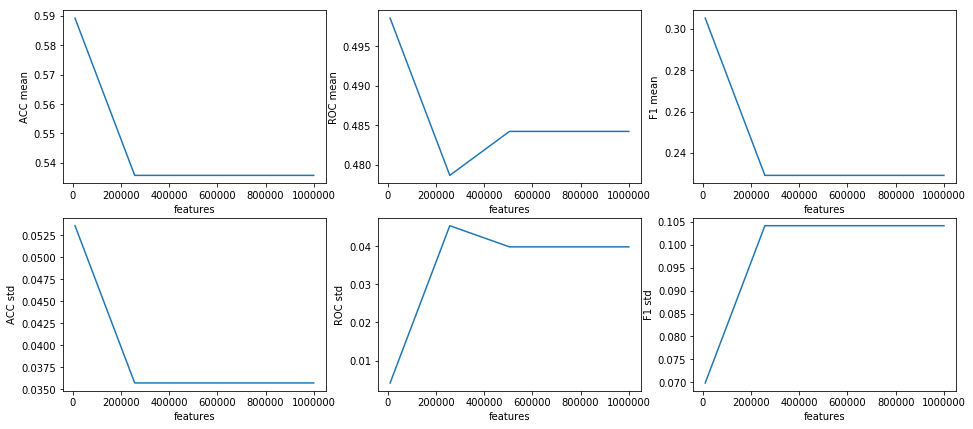

maximum at  10000.0  features


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide


accuracy test =  0.58064516129
roc test =  0.589743589744
f1 test =  0.0


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
clf1 = SVC(kernel='linear', probability = True)
clf2 = LogisticRegression(solver='liblinear', penalty='l2')
clf3 = LogisticRegression(solver='liblinear', penalty='l2')
#clf2 = SVC(kernel='linear', probability = True)
#clf3 = SVC(kernel='linear', probability = True)
linspace = np.linspace(10000, 1000000, num=5)
splits=2
ACC, ROC, F1, W = cross_validation_w_map_g(X, y, clf1, clf2, clf3, splits, linspace)

In [5]:
# build vector with dt's
dt=[]
for i in range(0,len(sub_id)):
    dt.append(Subjects[sub_id[i]].jacobians[jac_idx[i]].dt)

dt = np.asarray(dt)/365  

In [8]:
# build vector with ages
ages=[]
for i in range(0,len(sub_id)):
    ages.append(Subjects[sub_id[i]].age_bl)
    
ages = np.asarray(ages) 

In [6]:
def cross_validation_SelectPercentile(X, y, clf, splits, linspace, dt, ages):
    
    l=len(linspace)
    l2=X.shape[1]
    ACC=np.zeros((l))
    ROC=np.zeros((l))
    F1=np.zeros((l))
    MCC=np.zeros((l))
    APS=np.zeros((l))
    PREC=np.zeros((l))
    REC=np.zeros((l))
    
    ages=np.reshape(ages, (124,1))
    dt=np.reshape(dt, (124,1))
    
    spl2 = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    
    for train_index, test_index in spl2.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_test = dt[test_index]
        
        
        acc_l=[]
        roc_l=[]
        f1_l=[]
        mcc_l=[]
        aps_l=[]
        prec_l=[]
        rec_l=[]
        
        for n in linspace:
            
            y_test = y[test_index]
            dt_test = dt[test_index]
            
            print(n)
            S = SelectPercentile(percentile=n)
            #S = SelectKBest(f_classif, k=1000)
            S.fit(X_train, y_train)
            X_train_s = X_train[:,S.get_support()]
            X_test_s = X_test[:,S.get_support()]
            
          

            #X_train=np.concatenate((X_train, ages), axis=1)
            #X_train=np.concatenate((X_train, dt), axis=1)
            #X_tr=np.concatenate((X_train, ages), axis=1)
            #X_train=np.concatenate((X_train, dt), axis=1)
            
            
            
            y_score = clf.fit(X_train_s, y_train).decision_function(X_test_s)
            pred = clf.predict(X_test_s)
            
            mask0 = np.where(dt_test>1.09)#~400 days
            mask0 = np.asarray(mask0)
            pred = pred[mask0][0]
            y_test = y_test[mask0][0]
            y_score = y_score[mask0][0]
            
                
            acc = accuracy_score(y_test, pred)
            roc=roc_auc_score(y_test, y_score)
            f1=f1_score(y_test, pred)
            mcc=matthews_corrcoef(y_test, pred)
            aps=average_precision_score(y_test, y_score)
            precision=precision_score(y_test, pred)
            recall=recall_score(y_test, pred)
            
            acc_l.append(acc)
            roc_l.append(roc)
            f1_l.append(f1)
            mcc_l.append(mcc)
            aps_l.append(aps)
            prec_l.append(precision)
            rec_l.append(recall)
            
        ACC = np.vstack((ACC, acc_l))
        ROC = np.vstack((ROC, roc_l))
        F1 = np.vstack((F1, f1_l))
        MCC = np.vstack((MCC, mcc_l))
        APS = np.vstack((APS, aps_l))
        PREC = np.vstack((PREC, prec_l))
        REC = np.vstack((REC, rec_l))
        print(PREC.shape)
        
            
    ACC=ACC[1:,:]
    ROC=ROC[1:,:]
    F1=F1[1:,:]
    MCC=MCC[1:,:]
    APS=APS[1:,:]
    PREC=PREC[1:,:]
    REC=REC[1:,:]
    
    
    m1=np.mean(ACC, axis=0)
    dv1=np.std(ACC, axis=0)
    m2=np.mean(ROC, axis=0)
    dv2=np.std(ROC, axis=0)
    m3=np.mean(F1, axis=0)
    dv3=np.std(F1, axis=0)
    m4=np.mean(MCC, axis=0)
    dv4=np.std(MCC, axis=0)
    m5=np.mean(APS, axis=0)
    dv5=np.std(APS, axis=0)
    m6=np.mean(PREC, axis=0)
    dv6=np.std(PREC, axis=0)
    m7=np.mean(REC, axis=0)
    dv7=np.std(REC, axis=0)
    
    plt.figure(1)
    plt.plot(linspace, m1, color='green', label='acc')
    plt.plot(linspace, m2, color='red', label='roc')
    plt.plot(linspace, m3, color='blue', label='f1_score')
    plt.plot(linspace, m4, color='orange', label='mcc')
    plt.plot(linspace, m5, color='black', label='aps')
    plt.plot(linspace, m6, color='brown', label='precision')
    plt.plot(linspace, m7, color='yellow', label='recall')

    
    

    plt.legend(loc='best')
    plt.xlabel('percentile')
    plt.title('metrics logistic regression combination c1 and c2')
    plt.show()
    
    return m2, m5
    


0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 573917 573920 573921] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.625
1.0
1.375
1.75
(2, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    149    173 ..., 573904 573905 573906] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(3, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 573877 573887 573888] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(4, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   196    265    274 ..., 573917 573920 573921] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(5, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    177 ..., 573919 573920 573921] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(6, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    283    289 ..., 573896 573897 573898] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(7, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71     85    173 ..., 573917 573920 573921] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(8, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    80     85    173 ..., 573915 573916 573919] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(9, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 573915 573916 573919] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(10, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    275 ..., 573653 573654 573870] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(11, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    80     85    149 ..., 573915 573916 573919] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(12, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    173    174 ..., 573915 573916 573919] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(13, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   323    335    384 ..., 573888 573892 573893] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(14, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   275    291    348 ..., 573896 573897 573898] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(15, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    265 ..., 573917 573920 573921] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(16, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    178    179 ..., 573896 573897 573898] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(17, 5)
0.25
0.625
1.0
1.375
1.75
(18, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   265    283    289 ..., 573917 573920 573921] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(19, 5)
0.25
0.625
1.0
1.375
1.75
(20, 5)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    71    178    179 ..., 573912 573913 573914] are constant.
  UserWarning)


0.625
1.0
1.375
1.75
(21, 5)


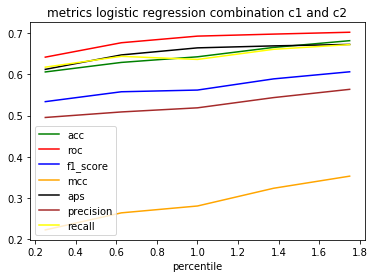

In [9]:
#clf = SVC(kernel='linear', probability = True, C=10000)
#X=np.transpose(np.transpose(X)/dt)
clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=1.25)
linspace = np.linspace(0.25, 1.75, num=5)
splits=20
roc, aps = cross_validation_SelectPercentile(X, y, clf, splits, linspace, dt, ages)

In [12]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, roc, linspace)

plt.plot(linspace, roc, color='red', label='roc')
exp = func(linspace, -0.3, popt[1], 0.7)
plt.plot(linspace, exp, color='blue', label='estimated exponential')

plt.legend(loc='best')
plt.xlabel('percentile')
plt.title('data vs. estimation')
plt.show()

optimal_point = 5 / popt[1]

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [18]:
optimal_point

0.086465688275188954

In [19]:
popt

array([ -2.58218598e+15,   5.78264061e+01,   1.03137595e+00])

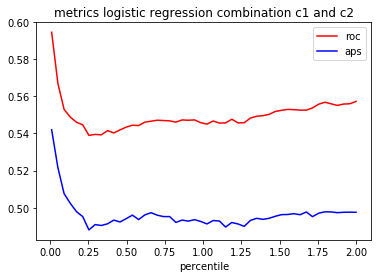

In [30]:
plt.figure(1)
plt.plot(linspace, roc, color='red', label='roc')
plt.plot(linspace, aps, color='blue', label='aps')
plt.legend(loc='best')
plt.xlabel('percentile')
plt.title('metrics logistic regression combination c1 and c2')
plt.show()

## same experiments but with all jacobians of each subject (288 jacobians)

In [3]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_dt.npy') 
#X2=np.load('/home/miquel/ForMiquel/CLEAN2/X_c2.npy')
#X3=np.load('/home/miquel/ForMiquel/CLEAN2/X_c3.npy')
#X=np.concatenate((X1, X2), axis=1)
#X=np.concatenate((X, X3), axis=1)
y=np.load('/home/miquel/ForMiquel/CLEAN2/y.npy') #jacobian labels
y_short=np.load('/home/miquel/ForMiquel/CLEAN2/y_short.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id.npy') #jacobian idxs
sub_id_short=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs

In [8]:
subjects_1_3_idx=[] #to store indices of subjects with jacobians of classes 1 or 3
labels=[]

#only subject indices with all jacobians of the same class (1 or 3) are stored
for s in range(0,len(Subjects)):
    counter1 = 0
    counter3 = 0
    for i in range(0,len(Subjects[s].jacobians)):
        if Subjects[s].jacobians[i].label == 1:
            counter1 = counter1 + 1
        if Subjects[s].jacobians[i].label == 3:
            counter3 = counter3 + 1
    if (counter1 == len(Subjects[s].jacobians) or counter3 == len(Subjects[s].jacobians)) and len(Subjects[s].jacobians) > 0:
        subjects_1_3_idx.append(s)
        if counter3 > counter1:
            labels.append(3)
        else:
            labels.append(1)

print("the list has a total of ", len(subjects_1_3_idx), " indices.")

the list has a total of  124  indices.


In [9]:
# build vector with dt's
dts=[]
for idx in subjects_1_3_idx:
    for j in Subjects[idx].jacobians:
        dts.append(j.dt)
print(np.shape(dts))
print(dts)
dt = np.asarray(dts)/365  

(288,)
[363, 388, 363, 380, 365, 378, 378, 724, 346, 378, 362, 720, 358, 355, 1814, 1459, 355, 1814, 1459, 359, 410, 358, 380, 1701, 2073, 1321, 1693, 372, 364, 1106, 1473, 1826, 742, 1109, 1462, 367, 720, 353, 383, 363, 1095, 1466, 1826, 732, 1103, 1463, 371, 731, 360, 397, 367, 368, 362, 720, 358, 369, 364, 1897, 1533, 371, 1464, 2182, 1093, 1811, 718, 367, 1094, 1452, 727, 1085, 358, 372, 1094, 1457, 722, 1085, 363, 381, 1094, 1465, 1850, 713, 1084, 1469, 371, 756, 385, 345, 364, 728, 364, 368, 1097, 729, 366, 369, 1099, 1460, 730, 1091, 361, 389, 357, 366, 360, 735, 375, 368, 1120, 1491, 1932, 752, 1123, 1564, 371, 812, 441, 404, 366, 1524, 1158, 366, 1107, 741, 366, 1107, 741, 395, 352, 371, 368, 371, 830, 1156, 459, 785, 326, 388, 783, 1108, 395, 720, 325, 378, 365, 381, 722, 1578, 341, 1197, 856, 353, 722, 1135, 369, 782, 413, 356, 351, 1114, 1588, 763, 1237, 474, 364, 767, 1106, 1477, 2265, 403, 742, 1113, 1901, 339, 710, 1498, 371, 1159, 788, 363, 1839, 1476, 378, 1099, 1456, 

In [12]:
def cross_validation_SelectPercentile_long(X, y, clf, splits, linspace, dt):
    
    l=len(linspace)
    l2=X.shape[1]
    ACC=np.zeros((l))
    ROC=np.zeros((l))
    F1=np.zeros((l))
    MCC=np.zeros((l))
    APS=np.zeros((l))
    PREC=np.zeros((l))
    REC=np.zeros((l))
    
    #ages=np.reshape(ages, (124,1))
    #dt=np.reshape(dt, (124,1))
        
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=42)
    for train_index, test_index in spl.split(sub_id_short, y_short): #split in subjects
        sub_id_train = sub_id_short[train_index] #search subject train idxs
        idx = np.isin(sub_id, sub_id_train) #match train idxs 
        X_train = X[idx,:]
        X_test = X[~idx,:]
        y_train = y[idx]
        y_test = y[~idx]
        
        
        acc_l=[]
        roc_l=[]
        f1_l=[]
        mcc_l=[]
        aps_l=[]
        prec_l=[]
        rec_l=[]
        
        for n in linspace:
            
            y_test = y[test_index]
            dt_test = dt[test_index]
            
            print(n)
            S = SelectPercentile(percentile=n)
            #S = SelectKBest(f_classif, k=1000)
            S.fit(X_train, y_train)
            X_train_s = X_train[:,S.get_support()]
            X_test_s = X_test[:,S.get_support()]
            
          

            #X_train=np.concatenate((X_train, ages), axis=1)
            #X_train=np.concatenate((X_train, dt), axis=1)
            #X_tr=np.concatenate((X_train, ages), axis=1)
            #X_train=np.concatenate((X_train, dt), axis=1)
            
            
            
            y_score = clf.fit(X_train_s, y_train).decision_function(X_test_s)
            pred = clf.predict(X_test_s)
            
            mask0 = np.where(dt_test>1.09)#~400 days
            mask0 = np.asarray(mask0)
            pred = pred[mask0][0]
            y_test = y_test[mask0][0]
            y_score = y_score[mask0][0]
            
                
            acc = accuracy_score(y_test, pred)
            roc=roc_auc_score(y_test, y_score)
            f1=f1_score(y_test, pred)
            mcc=matthews_corrcoef(y_test, pred)
            aps=average_precision_score(y_test, y_score)
            precision=precision_score(y_test, pred)
            recall=recall_score(y_test, pred)
            
            acc_l.append(acc)
            roc_l.append(roc)
            f1_l.append(f1)
            mcc_l.append(mcc)
            aps_l.append(aps)
            prec_l.append(precision)
            rec_l.append(recall)
            
        ACC = np.vstack((ACC, acc_l))
        ROC = np.vstack((ROC, roc_l))
        F1 = np.vstack((F1, f1_l))
        MCC = np.vstack((MCC, mcc_l))
        APS = np.vstack((APS, aps_l))
        PREC = np.vstack((PREC, prec_l))
        REC = np.vstack((REC, rec_l))
        print(PREC.shape)
        
            
    ACC=ACC[1:,:]
    ROC=ROC[1:,:]
    F1=F1[1:,:]
    MCC=MCC[1:,:]
    APS=APS[1:,:]
    PREC=PREC[1:,:]
    REC=REC[1:,:]
    
    
    m1=np.mean(ACC, axis=0)
    dv1=np.std(ACC, axis=0)
    m2=np.mean(ROC, axis=0)
    dv2=np.std(ROC, axis=0)
    m3=np.mean(F1, axis=0)
    dv3=np.std(F1, axis=0)
    m4=np.mean(MCC, axis=0)
    dv4=np.std(MCC, axis=0)
    m5=np.mean(APS, axis=0)
    dv5=np.std(APS, axis=0)
    m6=np.mean(PREC, axis=0)
    dv6=np.std(PREC, axis=0)
    m7=np.mean(REC, axis=0)
    dv7=np.std(REC, axis=0)
    
    plt.figure(1)
    plt.plot(linspace, m1, color='green', label='acc')
    plt.plot(linspace, m2, color='red', label='roc')
    plt.plot(linspace, m3, color='blue', label='f1_score')
    plt.plot(linspace, m4, color='orange', label='mcc')
    plt.plot(linspace, m5, color='black', label='aps')
    plt.plot(linspace, m6, color='brown', label='precision')
    plt.plot(linspace, m7, color='yellow', label='recall')

    
    

    plt.legend(loc='best')
    plt.xlabel('percentile')
    plt.title('metrics logistic regression combination c1 and c2')
    plt.show()
    
    return m2, m5
    

0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 573236 573239 573240] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


1.75
(2, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    205    285 ..., 573231 573232 573233] are constant.
  UserWarning)


1.75
(3, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    196    293 ..., 573231 573232 573233] are constant.
  UserWarning)


1.75
(4, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   355    375    385 ..., 573236 573239 573240] are constant.
  UserWarning)


1.75
(5, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    177 ..., 573238 573239 573240] are constant.
  UserWarning)


1.75
(6, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    285    293 ..., 573217 573218 573219] are constant.
  UserWarning)


1.75
(7, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    84    127    138 ..., 573236 573239 573240] are constant.
  UserWarning)


1.75
(8, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 573210 573211 573238] are constant.
  UserWarning)


1.75
(9, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    185    190 ..., 573234 573235 573238] are constant.
  UserWarning)


1.75
(10, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    235 ..., 573171 573179 573191] are constant.
  UserWarning)


1.75
(11, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    177    185 ..., 573228 573229 573238] are constant.
  UserWarning)


1.75
(12, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   173    174    185 ..., 573218 573219 573238] are constant.
  UserWarning)


1.75
(13, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    293    301 ..., 573217 573218 573219] are constant.
  UserWarning)


1.75
(14, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   277    293    301 ..., 573199 573200 573201] are constant.
  UserWarning)


1.75
(15, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   332    345    355 ..., 573236 573239 573240] are constant.
  UserWarning)


1.75
(16, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    89    127    138 ..., 573201 573202 573203] are constant.
  UserWarning)


1.75
(17, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   127    138    185 ..., 573234 573235 573238] are constant.
  UserWarning)


1.75
(18, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   285    479    545 ..., 573236 573239 573240] are constant.
  UserWarning)


1.75
(19, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   185    190    191 ..., 573200 573201 573238] are constant.
  UserWarning)


1.75
(20, 2)
0.25


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     89    178 ..., 573227 573228 573229] are constant.
  UserWarning)


1.75
(21, 2)


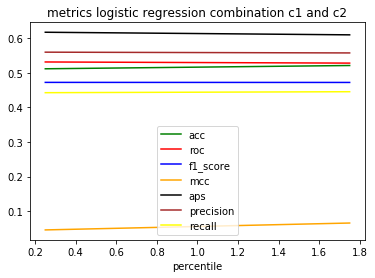

In [13]:
#clf = SVC(kernel='linear', probability = True, C=10000)
#X=np.transpose(np.transpose(X)/dt)
clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=1.25)
linspace = np.linspace(0.25, 1.75, num=2)
splits=20
roc, aps = cross_validation_SelectPercentile_long(X, y, clf, splits, linspace, dt)